In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc
import operator
import sklearn.metrics as metrics

In [2]:
directory = 'C:/githubrepo/7331_Project/data/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


### Functions for future use

In [3]:
# A function to find the optimal cutoff point from ROC curve

#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """Parameters:
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    ----------
    Return: list type, with optimal cutoff value
    """
    predicted = predicted[:,1]
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [4]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#probs is the result of a model.predict_proba(x_test) call

#This function plots an ROC curve
def rocCurvePlot(probs):
    # calculate the fpr and tpr for all thresholds of the classification
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Getting the column names of each type and making a dataframe of each

In [14]:
ordinal = ["age", "time_in_hospital"]
categorical = ["race", "gender", "admission_type_id", "discharge_disposition_id",
               "admission_source_id", "medical_specialty", "max_glu_serum",
               "A1Cresult", "change", "diabetesMed", "diag_1_val", "diag_2_val",
               "diag_3_val", "meds_increased"]
continuous = ["num_lab_procedures", "num_procedures", "num_medications",
              "number_outpatient", "number_emergency", "number_inpatient",
              "number_diagnoses", "medication_count"]
lcontinuous = ["lnum_lab_procedures", "lnum_procedures", "lnum_medications",
              "lnumber_outpatient", "lnumber_emergency", "lnumber_inpatient",
              "lnumber_diagnoses", "lmedication_count"]
medicines = ["metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
response = ["readmitted_tf"]

In [15]:
df_zg_ordinal = df_zg[ordinal]
df_zg_categorical = df_zg[categorical]
df_zg_continuous = df_zg[continuous]
df_zg_lcontinuous = np.log(df_zg_continuous)
df_zg_lcontinuous.columns = lcontinuous
df_zg_medicines = df_zg[medicines]
df_zg_response = df_zg[response]

### Make Age Ordinal

In [16]:
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ordinal.loc[df_zg_ordinal['age'] == val, 'age'] = i

### Making all categorical columns categorical

In [17]:
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['discharge_disposition_id'] = df_zg_categorical['discharge_disposition_id'].astype(object)
df_zg_categorical['admission_source_id'] = df_zg_categorical['admission_source_id'].astype(object)
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['meds_increased'] = df_zg_categorical['meds_increased'].astype(object)
#df_zg_response['readmitted_tf'] = df_zg_response['readmitted_tf'].astype(object)
print("Done")

Done


### Creating X and Y dataframes

In [18]:
df_zg_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous], axis = 1)
df_zg_num_x = pd.concat([df_zg_ordinal, df_zg_continuous], axis = 1)
df_zg_med_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous, df_zg_medicines], axis = 1)
df_zg_hot_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous], axis = 1)
df_zg_hot_med_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, pd.get_dummies(df_zg_medicines)], axis = 1)
df_zg_y = df_zg_response
print("Done")
#df_zg_lx = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_lcontinuous], axis = 1)
#df_zg_num_lx = pd.concat([df_zg_ordinal, df_zg_lcontinuous], axis = 1)
#df_zg_med_lx = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_lcontinuous, df_zg_medicines], axis = 1)
#df_zg_hot_lx = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_lcontinuous], axis = 1)
#df_zg_hot_med_lx = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_lcontinuous, pd.get_dummies(df_zg_medicines)], axis = 1)

Done


# Regular Logistic

In [19]:
#Setting up the training and test sets
x_train, x_test, y_train, y_test = train_test_split(df_zg_hot_x, df_zg_y, test_size = 0.2, random_state=7)
#x_train, x_test, y_train, y_test = train_test_split(df_zg_num_x, df_zg_y, test_size = 0.2, random_state=7)
x_train.reset_index()
y_train.reset_index()
x_test.reset_index()
y_test.reset_index()
x_train.shape, x_test.shape

((81412, 184), (20354, 184))

In [20]:
%%time
#Logistic Regression
model = LogisticRegression()
model.fit(x_train, y_train)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 6.46 s


In [21]:
# interpret the weights
# iterate over the coefficients
weights = model.coef_.T # take transpose to make a column vector
variable_names = x_train.columns
allWeight = zip(weights, variable_names)
allWeight = sorted(allWeight, key=lambda x: x[0])
for coef, name in allWeight:
    print(name, 'has weight of', coef[0])

discharge_disposition_id_11 has weight of -5.700398464737854
discharge_disposition_id_14 has weight of -2.7000546082994052
discharge_disposition_id_13 has weight of -1.7986746586318714
admission_source_id_9 has weight of -1.431682743833108
discharge_disposition_id_19 has weight of -0.9633735028897917
medical_specialty_Surgery-Cardiovascular/Thoracic has weight of -0.9382425372076224
admission_source_id_5 has weight of -0.8500552352710444
admission_type_id_4 has weight of -0.8038643570011736
admission_type_id_3 has weight of -0.7472474240946957
admission_source_id_4 has weight of -0.7453730803599892
admission_source_id_6 has weight of -0.7411382097057954
medical_specialty_Pediatrics-Endocrinology has weight of -0.6821686862786978
admission_type_id_5 has weight of -0.6786096911541909
admission_type_id_8 has weight of -0.6785492613645505
medical_specialty_DCPTEAM has weight of -0.6650250050178715
admission_source_id_2 has weight of -0.6530459305418624
admission_type_id_1 has weight of -0.

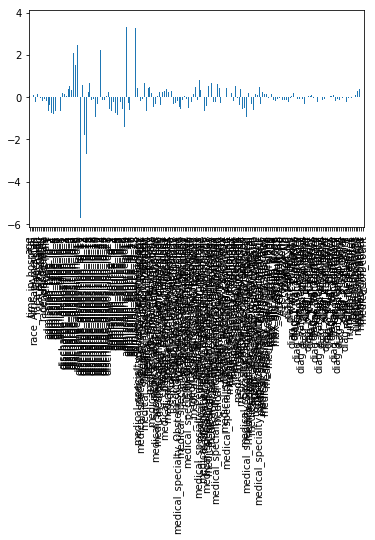

In [22]:
pd.Series(model.coef_[0].T,index=x_train.columns).plot(kind = 'bar')
plt.show()

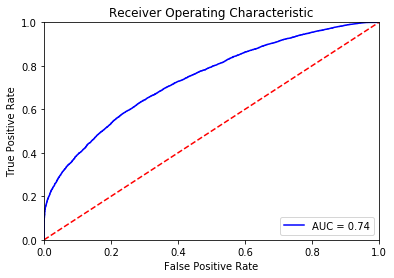

F1: 0.6702116623338857 ACC: 0.669794634961187 AUC: 0.7414110274351416 
Confusion Matrix
 [[7375 3594]
 [3127 6258]]


In [23]:
#Find the optimal cutoff point
y_pred_cut = model.predict_proba(x_train)
cutoff = Find_Optimal_Cutoff(y_train, y_pred_cut)

#Prediction
#y_pred = model.predict(x_test_scaled)
y_pred_probs = model.predict_proba(x_test)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs)

#Accuracy metrics
f1 = f1_score(y_test, y_pred, average = 'weighted')
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
conf = mt.confusion_matrix(y_test, y_pred)
print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)

### Regular Logistic Scaled

In [24]:
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(x_train)
x_test_scaled = scl_obj.transform(x_test)

x_train_scaled = scl_obj.transform(x_train)
x_test_scaled = scl_obj.transform(x_test)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  import sys
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


In [25]:
%%time
#Logistic Regression
model = LogisticRegression()
model.fit(x_train_scaled, y_train)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 6.17 s


In [26]:
# interpret the weights
# iterate over the coefficients
weights = model.coef_.T # take transpose to make a column vector
variable_names = x_train.columns
allWeight = zip(weights, variable_names)
allWeight = sorted(allWeight, key=lambda x: x[0])
for coef, name in allWeight:
    print(name, 'has weight of', coef[0])

discharge_disposition_id_11 has weight of -1.199036554267226
discharge_disposition_id_14 has weight of -0.17529643461069097
admission_source_id_2 has weight of -0.14537450643688543
discharge_disposition_id_13 has weight of -0.12277814401477867
admission_source_id_1 has weight of -0.12035595812734554
admission_type_id_4 has weight of -0.1115288280360183
admission_type_id_3 has weight of -0.10621221998322154
admission_source_id_4 has weight of -0.07868803804028683
medical_specialty_InternalMedicine has weight of -0.07669062844095378
medical_specialty_Surgery-Cardiovascular/Thoracic has weight of -0.07567449750016497
admission_source_id_6 has weight of -0.07558813722804661
admission_source_id_17 has weight of -0.07363452556878534
discharge_disposition_id_19 has weight of -0.06865713240320882
admission_type_id_1 has weight of -0.06426179297001386
medical_specialty_Orthopedics-Reconstructive has weight of -0.05982873739902399
medical_specialty_DCPTEAM has weight of -0.05790799554404062
medi

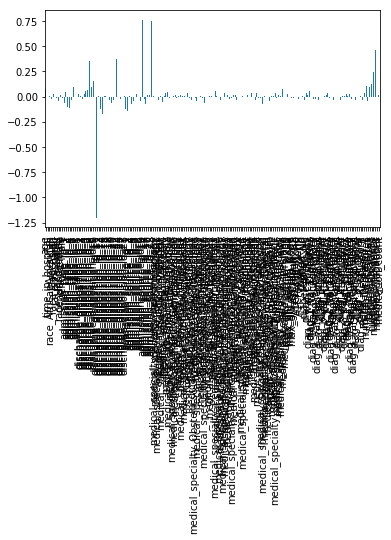

In [75]:
pd.Series(model.coef_[0].T, index = x_train.columns).plot(kind = 'bar')
plt.show()

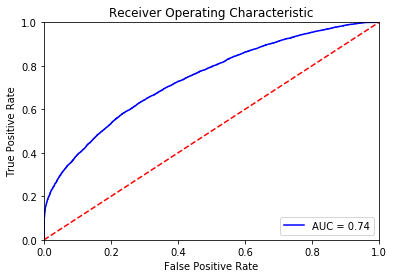

F1: 0.6698159786647345 ACC: 0.6694015918247027 AUC: 0.7414869133057841 
Confusion Matrix
 [[7374 3595]
 [3134 6251]]


In [27]:
#Find the optimal cutoff point
y_pred_cut = model.predict_proba(x_train_scaled)
cutoff = Find_Optimal_Cutoff(y_train, y_pred_cut)

#Prediction
#y_pred = model.predict(x_test_scaled)
y_pred_probs = model.predict_proba(x_test_scaled)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs)

#Accuracy metrics
f1 = f1_score(y_test, y_pred, average = 'weighted')
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, model.predict_proba(x_test_scaled)[:,1])
conf = mt.confusion_matrix(y_test, y_pred)
print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)

### Regular Logistic with Medications

In [28]:
#Setting up the training and test sets
x_train, x_test, y_train, y_test = train_test_split(df_zg_hot_med_x, df_zg_y, test_size = 0.2, random_state=7)
#x_train, x_test, y_train, y_test = train_test_split(df_zg_num_x, df_zg_y, test_size = 0.2, random_state=7)
x_train.reset_index()
y_train.reset_index()
x_test.reset_index()
y_test.reset_index()
x_train.shape, x_test.shape

((81412, 251), (20354, 251))

In [29]:
%%time
#Logistic Regression
model = LogisticRegression()
model.fit(x_train, y_train)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 9.53 s


In [30]:
# interpret the weights
# iterate over the coefficients
weights = model.coef_.T # take transpose to make a column vector
variable_names = x_train.columns
allWeight = zip(weights, variable_names)
allWeight = sorted(allWeight, key=lambda x: x[0])
for coef, name in allWeight:
    print(name, 'has weight of', coef[0])

discharge_disposition_id_11 has weight of -5.687000885917768
discharge_disposition_id_14 has weight of -2.699368821620567
discharge_disposition_id_13 has weight of -1.7703747450584482
admission_source_id_9 has weight of -1.4291007938208673
discharge_disposition_id_19 has weight of -0.9449989327546094
medical_specialty_Surgery-Cardiovascular/Thoracic has weight of -0.9378343619786118
admission_source_id_5 has weight of -0.8252405545342675
admission_type_id_4 has weight of -0.7705486708802
glyburide-metformin_Up has weight of -0.743779349602651
admission_source_id_4 has weight of -0.7368353793573432
admission_source_id_6 has weight of -0.7263628869127727
medical_specialty_Pediatrics-Endocrinology has weight of -0.7207053685556961
admission_type_id_3 has weight of -0.7129853684983268
medical_specialty_DCPTEAM has weight of -0.6633103980188303
admission_type_id_5 has weight of -0.6605506031581062
admission_type_id_8 has weight of -0.6558423139964561
admission_source_id_2 has weight of -0.6

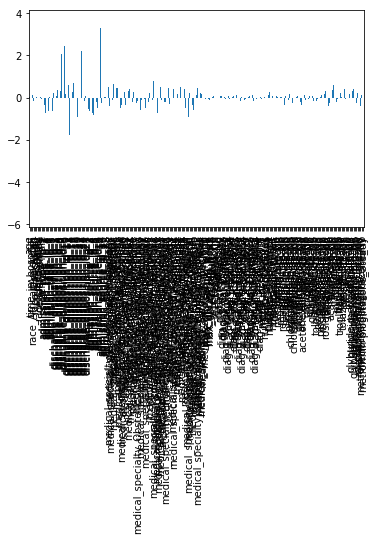

In [31]:
pd.Series(model.coef_[0].T,index=x_train.columns).plot(kind = 'bar')
plt.show()

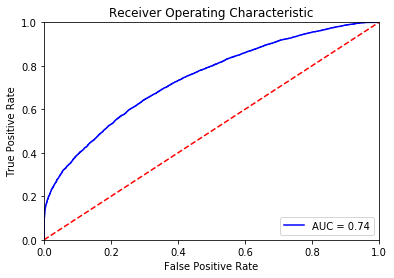

F1: 0.671507678095125 ACC: 0.6710720251547607 AUC: 0.7419343116089305 
Confusion Matrix
 [[7367 3602]
 [3093 6292]]


In [32]:
#Find the optimal cutoff point
y_pred_cut = model.predict_proba(x_train)
cutoff = Find_Optimal_Cutoff(y_train, y_pred_cut)

#Prediction
#y_pred = model.predict(x_test_scaled)
y_pred_probs = model.predict_proba(x_test)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs)

#Accuracy metrics
f1 = f1_score(y_test, y_pred, average = 'weighted')
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
conf = mt.confusion_matrix(y_test, y_pred)
print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)

### Regular Logistic with Medications and Scaled

In [33]:
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(x_train)
x_test_scaled = scl_obj.transform(x_test)

x_train_scaled = scl_obj.transform(x_train)
x_test_scaled = scl_obj.transform(x_test)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  import sys
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


In [34]:
%%time
#Logistic Regression
model = LogisticRegression()
model.fit(x_train_scaled, y_train)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 11.1 s


In [35]:
# interpret the weights
# iterate over the coefficients
weights = model.coef_.T # take transpose to make a column vector
variable_names = x_train.columns
allWeight = zip(weights, variable_names)
allWeight = sorted(allWeight, key=lambda x: x[0])
for coef, name in allWeight:
    print(name, 'has weight of', coef[0])

discharge_disposition_id_11 has weight of -1.1940923772942498
discharge_disposition_id_14 has weight of -0.1762143235037867
admission_source_id_2 has weight of -0.1471561691811736
discharge_disposition_id_13 has weight of -0.1219193908207502
admission_source_id_1 has weight of -0.12097596328158469
admission_type_id_4 has weight of -0.1109991908473792
admission_type_id_3 has weight of -0.10513049793857958
admission_source_id_4 has weight of -0.07992134826886066
metformin_Steady has weight of -0.07809797458432896
medical_specialty_InternalMedicine has weight of -0.07655489901268887
admission_source_id_6 has weight of -0.07564126093383582
medical_specialty_Surgery-Cardiovascular/Thoracic has weight of -0.07551957916217557
admission_source_id_17 has weight of -0.07220230722692748
discharge_disposition_id_19 has weight of -0.06830756092192795
glyburide-metformin_Up has weight of -0.06719941162329698
admission_type_id_1 has weight of -0.06467434058943923
insulin_Down has weight of -0.0642093

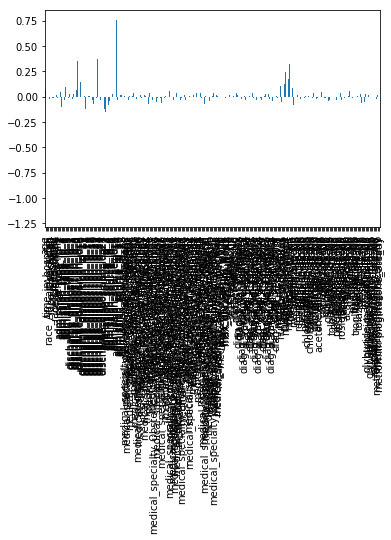

In [36]:
pd.Series(model.coef_[0].T, index = x_train.columns).plot(kind = 'bar')
plt.show()

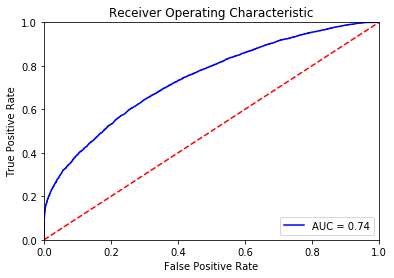

F1: 0.6713105163370111 ACC: 0.6708755035865186 AUC: 0.7419987932281478 
Confusion Matrix
 [[7366 3603]
 [3096 6289]]


In [37]:
#Find the optimal cutoff point
y_pred_cut = model.predict_proba(x_train_scaled)
cutoff = Find_Optimal_Cutoff(y_train, y_pred_cut)

#Prediction
#y_pred = model.predict(x_test_scaled)
y_pred_probs = model.predict_proba(x_test_scaled)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs)

#Accuracy metrics
f1 = f1_score(y_test, y_pred, average = 'weighted')
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, model.predict_proba(x_test_scaled)[:,1])
conf = mt.confusion_matrix(y_test, y_pred)
print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)

# SGD Logistic

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [38]:
regularize_const = 0.1
iterations = 5
# use some compact notation for creating a logistic regression classifier with stochastic descent
log_sgd = SGDClassifier(alpha = regularize_const,
        fit_intercept = True, l1_ratio = 0.0, learning_rate = 'optimal',
        loss = 'log', n_iter = iterations, n_jobs = -1, penalty = 'l2')

scl = StandardScaler()
log_sgd.fit(scl.fit_transform(x_train), y_train)
y_pred = log_sgd.predict(scl.transform(x_test))
conf = mt.confusion_matrix(y_test, y_pred)
acc = mt.accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = 'weighted')

print('Acc:', acc, "F1:", f1, '\nConfusion Matrix\n', conf)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acc: 0.6673381153581606 F1: 0.6550610012234589 
Confusion Matrix
 [[9131 1838]
 [4933 4452]]


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


### Prediction using the Logistic SGD with CV... its bad

In [39]:
cv = StratifiedShuffleSplit( n_splits = 1, test_size = 0.5 )
scl = StandardScaler()
for train_idx, test_idx in cv.split(x_train, y_train):
    log_sgd.fit(scl.fit_transform(x_train.iloc[train_idx]), y_train.iloc[train_idx])
    yhat = log_sgd.predict(scl.transform(x_train.iloc[test_idx]))
    
    conf = mt.confusion_matrix(y_train.iloc[test_idx], yhat)
    acc = mt.accuracy_score(y_train.iloc[test_idx], yhat)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\

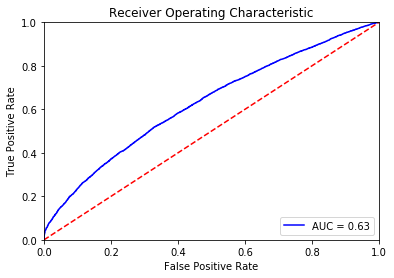

F1: 0.5905162613248862 ACC: 0.5899086174707674 AUC: 0.6292585201487818 
Confusion Matrix
 [[6460 4509]
 [3838 5547]]


In [41]:
#y_pred = log_sgd.predict(x_test)

#Accuracy metrics
#f1 = f1_score(y_test, y_pred, average = 'weighted')
#acc = accuracy_score(y_test, y_pred)
#roc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
#conf = mt.confusion_matrix(y_test, y_pred)
#print(f1, acc, roc)
#print('Accuracy:', acc, '\nConfusion Matrix\n', conf)

#------------------------
#Find the optimal cutoff point
y_pred_cut = model.predict_proba(x_train)
cutoff = Find_Optimal_Cutoff(y_train, y_pred_cut)

#Prediction
#y_pred = model.predict(x_test_scaled)
y_pred_probs = model.predict_proba(x_test)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs)

#Accuracy metrics
f1 = f1_score(y_test, y_pred, average = 'weighted')
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
conf = mt.confusion_matrix(y_test, y_pred)
print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)